In [1]:
# import necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import os
mypath = os.getcwd()
mypath

'/Users/sarahsobri/Desktop/Face-Mask-Detection-master'

In [3]:
# initialize the initial learning rate, number of epochs to train for and batch size
INIT_LR = 1e-4
EPOCHS =20
BS = 32

DIRECTORY = r'/Users/sarahsobri/Desktop/Face-Mask-Detection-master/dataset'
CATEGORIES = ['with_mask', 'without_mask'] #folders in the directory

In [4]:
# grab the list of images in our dataset directory, then initialize
# the list of data and class images
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

data = [] 
labels =[]

for category in CATEGORIES:
  path = os.path.join(DIRECTORY,category)
  for img in os.listdir(path):
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size=(224,224)) #height and width of image uniformly converted
    image = img_to_array(image) #convert the image to array
    image = preprocess_input(image) 

    data.append(image) #append image to the data list #the data is now in numerical value
    labels.append(category) #append the category into the labels list #label is still available value. converted

/Users/sarahsobri/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype='float32')
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data,labels,
                                                  test_size=0.2, stratify=labels, random_state=42)

In [7]:
# construct the training iamge generator for data augmentation
# data augmentation- adding various properties. more dataset from one image
aug = ImageDataGenerator( 
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
#construct the MobileNetV2 network, ensuring the head FC layer sets are left off

BaseModel1 = MobileNetV2(weights='imagenet', include_top=False,
                        input_tensor=Input(shape=(224,224,3))) #colour channels is 3 - RGB

In [14]:
for layer in BaseModel1.layers:
    layer.trainable = False # load the weights of VGg16 and freeze them

In [15]:
#construct the head of the model that will be placed on top of the base model

def layer_add(HeadModel1, num_classes):
    HeadModel1 = HeadModel1.output
    HeadModel1 = AveragePooling2D(pool_size=(7,7))(HeadModel1)
    HeadModel1 = Flatten(name='flatten')(HeadModel1)
    HeadModel1 = Dense(128, activation='relu')(HeadModel1)
    HeadModel1 = Dropout(0.5)(HeadModel1)#prevent overfitting
    HeadModel1 = Dense(2, activation='softmax')(HeadModel1)
    return HeadModel1

In [17]:
# set the class number to 2 (mask, without mask)
# add new layers for fine-tuning
num_classes = 2
FC_head1 = layer_add(BaseModel1, num_classes)

final_model_MN = Model(inputs = BaseModel1.input, outputs = FC_head1)

final_model_MN.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [9]:
#construct the head of the model that will be placed on top of the base model

#HeadModel1 = BaseModel1.output
#HeadModel1 = AveragePooling2D(pool_size=(7,7))(HeadModel1)
#HeadModel1 = Flatten(name='flatten')(HeadModel1)
#HeadModel1 = Dense(128, activation='relu')(HeadModel1)
#HeadModel1 = Dropout(0.5)(HeadModel1) #prevent overfitting
#HeadModel1 = Dense(2, activation='softmax')(HeadModel1)

In [10]:
#place the head FC model on top of the base model (this will become the actual model we will train)

#MNmodel = Model(inputs=BaseModel1.input, outputs=HeadModel1)

In [11]:
#MNmodel.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [18]:
#compile out mode
optimizer =Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
final_model_MN.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

#train the head of the network
print('[INFO] training head...')
History1 = final_model_MN.fit(
    aug.flow(trainX,trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS, validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 147s 2s/step - loss: 0.2896 - accuracy: 0.8774 - val_loss: 0.0991 - val_accuracy: 0.9752
Epoch 2/20
95/95 [==============================] - 142s 1s/step - loss: 0.1036 - accuracy: 0.9644 - val_loss: 0.0694 - val_accuracy: 0.9791
Epoch 3/20
95/95 [==============================] - 138s 1s/step - loss: 0.0784 - accuracy: 0.9756 - val_loss: 0.0597 - val_accuracy: 0.9817
Epoch 4/20
95/95 [==============================] - 149s 2s/step - loss: 0.0714 - accuracy: 0.9740 - val_loss: 0.0645 - val_accuracy: 0.9804
Epoch 5/20
95/95 [==============================] - 163s 2s/step - loss: 0.0484 - accuracy: 0.9852 - val_loss: 0.0485 - val_accuracy: 0.9831
Epoch 6/20
95/95 [==============================] - 165s 2s/step - loss: 0.0480 - accuracy: 0.9822 - val_loss: 0.0452 - val_accuracy: 0.9844
Epoch 7/20
95/95 [==============================] - 154s 2s/step - loss: 0.0455 - accuracy: 0.9862 - val_loss: 0.0454 - val_accura

In [19]:
# make predictions on the testing set
prediction = final_model_MN.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
prediction = np.argmax(prediction, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), prediction,
	target_names=lb.classes_))

# serialize the model to disk
final_model_MN.save("mobilenetv2_mask_detector.model", save_format="h5")

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       383
without_mask       1.00      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



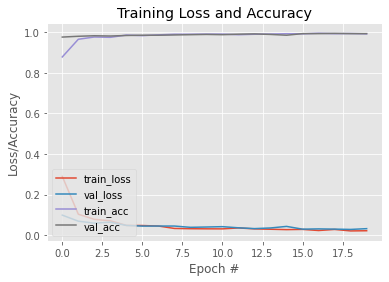

In [20]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), History1.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History1.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), History1.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), History1.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [25]:
pip install graphviz

     |████████████████████████████████| 46 kB 3.0 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


In [21]:
from tensorflow.keras.utils import plot_model

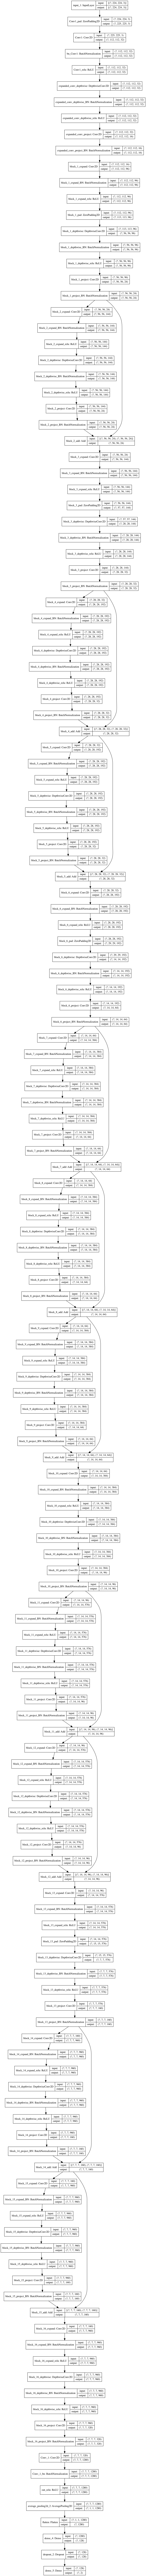

In [22]:
plot_model(final_model_MN, to_file='mobilenetv2_model_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [31]:
sudo port install graphviz

SyntaxError: invalid syntax (<ipython-input-31-4f6a2c0cbf18>, line 1)